In [1]:
%reset

import numpy as np
import pickle as pk
import matplotlib.pyplot as pl
from astropy import units
from astropy import constants
import matplotlib
from astropy.io import fits
# %pylab inline

# Color = ['#0072b1','#009d73','#d45e00','k', 'grey','yellow']

Color = ['k', '#000075', '#a9a9a9','#9A6324', '#808000','#aaffc3', '#fffac8'  ,'#800000', '#ffd8b1',]

font = {'size'   : 18}
matplotlib.rc('font', **font)
# # Latex stuff
pl.rc('text', usetex=False)
pl.rc('font', family='serif')

# %matplotlib inline



Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
def corr_mat(cov):
    dims = cov.shape
    corr = np.zeros(dims)
    for ii in range(0,dims[0]):
        for jj in range(0,dims[1]):
            corr[ii,jj] = cov[ii,jj]/np.sqrt(cov[ii,ii]*cov[jj,jj])

    return corr

import math
import numpy as np

the_gold_standard = { 0: (203.0/255.0, 15.0/255.0, 40.0/255.0),
                      1: (255.0/255.0, 165.0/255.0, 0.0),
                      2: (42.0/255.0, 46.0/255.0, 139.0/255.0),
                      3: (0.0/255.0, 153.0/255.0, 204.0/255.0),
                      4: (0.0/255.0, 221.0/255.0, 52.0/255.0),
                      5: (0.0, 0.75, 0.75),
                      6: (0.0, 0.0, 0.0),
                    }

# ******************************************************************************
# definition of color interpolation utilities:

def color_linear_interpolation( rgb_1, rgb_2, alpha ):
    """
    This function performs a linear color interpolation in RGB space.
    alpha has to go from zero to one and is the coordinate.
    """
    _out_color = []
    for _a,_b in zip(rgb_1,rgb_2):
        _out_color.append( float(_a +(_b-_a)*alpha) )
    return tuple(_out_color)


def nice_colors( num, colormap='the_gold_standard', interpolation_method='linear', output_format='RGB' ):
    """
    This function returns a color from a colormap defined above, according to the
    number entered.

    :param num: input number. Can be an integer or float.
        If the number is integer the function returns one of the colors in the
        colormap. If the number is a float returns the shade combining the two
        neighbouring colors.
    :type num: :class:`int` or :class:`float`

    :param colormap: a string containing the name of the colormap.
    :type colormap: :class:`string`

    :param interpolation_method: the method to interpolate between colors.
        Legal choices are:
            interpolation_method='linear', linear interpolation;
        Further interpolation methods will be added in the future.
    :type interpolation_method: :class:`string`

    :param output_format: output format of the color.
        Legal choices are:
            output_format='HEX'
            output_format='RGB' (default)
    :type output_format: :class:`string`

    :return: string with HEX color or tuple with RGB coordinates

    """
    # get the colormap:
    try:
        _cmap = globals()[str(colormap)]
    except:
        raise ValueError('Requested color map ('+str(colormap)+') does not exist.')
    # get the indexes of the color map:
    _idx_low = int( math.floor(num%len(_cmap)) )
    _idx_up  = int( math.floor((_idx_low+1)%len(_cmap)) )
    # perform color interpolation:
    if interpolation_method=='linear':
        _t = num%len(_cmap)-_idx_low
        _out_color = color_linear_interpolation(_cmap[_idx_low],_cmap[_idx_up],_t)
    else:
        raise ValueError('Requested color interpolation method ('+str(interpolation_method)+') does not exist.')
    # choose the output format:
    if output_format=='HEX':
        _out_color = '#%02x%02x%02x' % tuple( [ int(_c*255.) for _c in _out_color] )
        _out_color = str(_out_color)
    elif output_format=='RGB':
        pass
    else:
        raise ValueError('Requested output format ('+str(output_format)+') does not exist.')
    #
    return _out_color





In [3]:
cat = 'halos'

if cat == 'maglim':
    fname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_data.fits'
    df = fits.open(fname)
    datapoint_z_all = df[1].data['z_dnf_mean_sof']
    datapoint_zmc_all = df[1].data['z_dnf_mc_sof']
    datapoint_ra_all = df[1].data['ra_gal']
    datapoint_dec_all = df[1].data['dec_gal']

if cat == 'halos':
    logMmin = 13.0
    logMmax = 13.5
    fname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_all_halos.fits'
    df = fits.open(fname)
    datapoint_z_all = df[1].data['z_cgal']
    datapoint_ra_all = df[1].data['ra_gal']
    datapoint_dec_all = df[1].data['dec_gal']
    datapoint_M_all = df[1].data['lmhalo']
    ind_sel = np.where((datapoint_M_all > logMmin) & (datapoint_M_all < logMmax))[0]
    datapoint_ra_all, datapoint_dec_all, datapoint_z_all = datapoint_ra_all[ind_sel], datapoint_dec_all[ind_sel], datapoint_z_all[ind_sel]
    
zmin_bins = np.array([0.20, 0.40, 0.55, 0.70, 0.85, 0.95])
zmax_bins = np.array([0.40, 0.55, 0.70, 0.85, 0.95, 1.05 ])






In [5]:
csf = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/MICE_maglim_nz_fidfile.fits'

csfd = fits.open(csf)
# csfd['nz_lens'].header




In [6]:
z_min, z_max = 0.0, 2.5
nzbins_total = 250
zarray_all = np.linspace(z_min, z_max, nzbins_total)
zarray_edges = np.append(csfd['nz_lens'].data['Z_LOW'],csfd['nz_lens'].data['Z_HIGH'][-1])
zarray = csfd['nz_lens'].data['Z_MID']


    
    

In [8]:
import scipy.integrate as integrate
nz_norm_all = np.zeros((len(zmin_bins),len(zarray)))
for jz in range(len(zmin_bins)):

    print('doing z bin:' + str(jz))
    minz = zmin_bins[jz]
    maxz = zmax_bins[jz]
    # Restrict to datapoint selection
    selection_z = np.where((datapoint_z_all > minz) & (datapoint_z_all < maxz))[0]
    print("num in selection = ", selection_z.shape)
    data_zmc_sel = datapoint_z_all[selection_z]
    nz_unnorm, z_edge = np.histogram(data_zmc_sel, zarray_edges)
    nz_norm = nz_unnorm/integrate.simps(nz_unnorm,zarray)
    nz_norm_all[jz,:] = nz_norm
    







doing z bin:0
num in selection =  (135424,)
doing z bin:1
num in selection =  (195320,)
doing z bin:2
num in selection =  (262908,)
doing z bin:3
num in selection =  (305196,)
doing z bin:4
num in selection =  (220279,)
doing z bin:5
num in selection =  (222702,)


(0, 1.3)

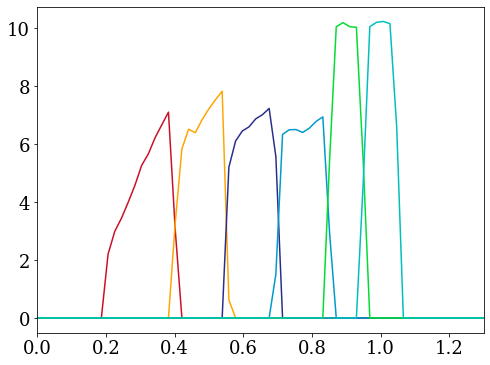

In [9]:
fig, ax = pl.subplots(1,1)
fig.set_size_inches((8,6)) 

for jz in range(len(zmin_bins)):
    ax.errorbar(zarray,nz_norm_all[jz,:],color=nice_colors(jz),ls='-',label='Bin ' + str(jz+1))

# ax.errorbar(theta_array, xi_w1,  label = labels[j], linestyle=linestyles[j])
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0,1.3)
# ax.set_ylim(-1e-7,2e-7)
# ax.set_ylabel(r'$\ell (\ell + 1) C_{\ell} / 2\pi$')
# ax.set_xlabel(r'$\ell$')
# ax.legend()
# # ax.set_title('ACT v1 x Redmagic Y3')
# ax.set_title('ACT v1 x Maglim Y3')









In [10]:
zlow = zarray_edges[:-1]
zhigh = zarray_edges[1:]
zmid = zarray

if cat == 'maglim':
    fname = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/MICE_maglim_nz_fidfile.fits'
    
if cat == 'halos':
    fname = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/MICE_halos_nz_fidfile.fits'

with fits.open(fname, mode='update') as hdul:  
    hdul['nz_lens'].data['Z_LOW'] = zlow
    hdul['nz_lens'].data['Z_MID'] = zmid
    hdul['nz_lens'].data['Z_HIGH'] = zhigh
    bins_array = [1,2,3,4,5,6]
    jz = 0
    for bins in bins_array:
        hdul['nz_lens'].data['BIN' + str(bins)] = nz_norm_all[jz,:]
        jz += 1
    hdul.flush()

    
    